=====================================================================================
Séries temporais apresentam algumas características que impactam o desenvolvimento
de modelos de aprendizagem de máquina, como sazonalidade (seasonality), 
tendência (trend), auto-correlação, dentre outras.

Este notebook utiliza algumas práticas para a modelagem de uma série 
temporal que contém a concentração de CO2 em ppm fornecido pelo observatório 
Maina Loa, parte da Administração Nacional Oceânica e Atmosférica (NOAA) 
e comparar os resultados obtidos.

Os dados cobrem o período de março de 1958 a setembro de 2022, com informações 
mensais; não existem dados inválidos nas observações.

O valor mínimo da série é de 313.33 ppm, obtido em outubro de 1959, e o valor 
máximo da série é de 419.13 ppm, obtido em maio de 2021. 

As medições têm valor médio de 357.339 ppm, desvio padrão de 29.688 e 
skew de 0.349.

A variável 'average' representa o valor médio mensal da concentração de CO2; 
essa variável será a variável alvo do modelo desenvolvido.
    
Os dados foram obtidos em: https://gml.noaa.gov/ccgg/trends/

Estratégia:
    A estratégia utilizada para o desenvolvimento do modelo foi composta por 
    4 passos:
        1)  Treinamento de um modelo de regressão linear com variáveis que 
            representam o mês e o ano de cada observação e uma sequencia de
            variáveis com a concentração de CO2 dos meses anteriores; os dados
            de treino cobriam o período de 01 de 1960 a 12 de 2009; os dados 
            de teste de 01/2010 a 12/2019. O menor erro medido pela métrica 
            rmse foi 0.443.
        2)  A mesma aboragem anterior, com perído de treino (10 anos,
            01/2010 a 12/2019) e teste (2 anos, 01/2020 a 12/2021) menores - 
            uma tentativa de explorar a taxa de crescimento da série temporal.
            O menor erro obtido foi de 0.331.
        3)  Utilização de uma janela de treinamento mais curta (120 meses) e 
            uma janela de teste com 24 meses; o valor médio do erro nesse 
            passo foi de 0.445.
        4)  Utilização de mais uma variável independente, que representa a 
            sazonalidade da série temporal analisada, obtida pela rotina 
            seasonal_decompose, disponível no módulo statsmodels.tsa.seasonal, 
            que decompÕe uma série temporal em 3 componentes: tendência, 
            sazonalidade e ruído; também foram empregadas as jamelas 
            de tamanhos idênticos às utilizadas nos passo anterior. Nesse caso 
            o valor médio do erro foi de 0.421.
        Os passos 3 e 4, de certa forma, realizam uma "validação cruzada" no 
        modelo, adaptada às características da série temporal analisada, que
        possui uma taxa de crescimento que se acelara ao longo dos anos, 
        como observado nos gráficos gerados.

@author: Miguel Argollo, miguel.argollo@gmail.com.

In [1]:
# Bibliotecas utilizadas

#   Básicas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#   Gerais

import time

#   sklearn - métricas

from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#   sklearn - modelos

from sklearn.linear_model import LinearRegression

#from dateutil.parser import parse
from statsmodels.tsa.seasonal import seasonal_decompose

from datetime import date

print('\n>>>   Final da carga das bibliotecas.\n')


>>>   Final da carga das bibliotecas.



In [2]:
df = pd.read_csv('../Data/co2_month.csv', 
                 parse_dates=[['year', 'month']])
target = 'average'
df=df[['year_month', target]]

Para facilitar o tratamento da sazonalidade dos dados somente as medições 
entre janeiro de 1959 e dezembro de 2021 serão utilizadas.

In [3]:
df = df[df['year_month'].between('1959-01-01', '2021-12-01')]
df = df.set_index('year_month')

log_target = 'log_average'
df[log_target] = np.log(df[target])

In [4]:
print(f'\nDimensões dos dados de entrada: {df.shape[0]} observações, {df.shape[1]} variáveis.')
print(f'Primeira observação em: {df.index.min()}')
print(f'Observação final em: {df.index.max()}')
target_min = df[target].min()
dt_min = df[df[target] == target_min].index
print(f'Valor mínimo da série: {round(target_min, 3)}, em: {dt_min.month_name()[0]}, {dt_min.year[0]}') 
target_max = df[target].max()
dt_max = df[df[target] == target_max].index
print(f'Valor máximo da série: {round(target_max, 3)}, em: {dt_max.month_name()[0]}, {dt_max.year[0]}')
print (f'Valor médio da série: {round(df[target].mean(), 3)}')
print(f'Desvio padrão da série: {round(df[target].std(), 3)}')
print(f'Skew da variável target sem transformação: {round(df[target].skew(),3)}')
print(f'Skew da variável target com transformação: {round(df[log_target].skew(),3)}\n')


Dimensões dos dados de entrada: 756 observações, 2 variáveis.
Primeira observação em: 1959-01-01 00:00:00
Observação final em: 2021-12-01 00:00:00
Valor mínimo da série: 313.33, em: October, 1959
Valor máximo da série: 419.13, em: May, 2021
Valor médio da série: 357.339
Desvio padrão da série: 29.688
Skew da variável target sem transformação: 0.349
Skew da variável target com transformação: 0.248



# Gerando novas variáveis independentes

Acrescentando o ano e o mês em que cada medição foi obtida, bem como a numeração
sequencial das medições (janeiro de 1959:0; fevereiro de 1959: 1; ...
dezembro de 2021: 755.
Esses dados serão utilizados nos gráficos e modelos desenvolvidos)

In [5]:
df['month'] = df.index.month 
df['year'] = df.index.year
df['indice'] = range(0, len(df))

# Auto correlação
Séries temporais muitas vezes apresentam auto-correlação - a medição de 
um mês está relacionada com as medições dos meses anteriores.
Serão geradas variáveis lag_1 (valor do último mês), lag_2 (valor do penúltimo 
mês), ... lag_12.

In [6]:
for ind in range(1, 13):
    df['lag_' + str(ind)] = df[target].shift(ind)

df=df.dropna()

Gráficos são úteis na compreensão e análise iniciais dos dados.
O primeiro gráfico mostra a evolução da concentração média mensal de CO2.
É possível observar a tendência de crescimento desta concentração 
na atmosfera.

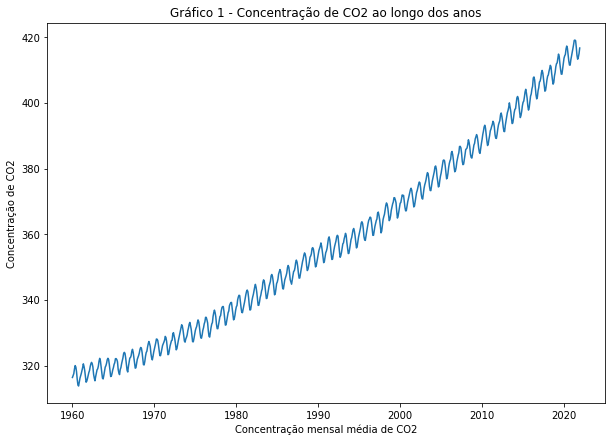

In [7]:
plt.subplots(figsize=(10,7), linewidth=0.5)
#sns.regplot(x=df.index.year, y='average', data=df, marker='.')
plt.plot(target, data=df)
plt.ylabel('Concentração de CO2')
plt.xlabel('Concentração mensal média de CO2')
plt.title('Gráfico 1 - Concentração de CO2 ao longo dos anos')
plt.show()

O próximo gráfico representa os valores de CO2 consolidados por mês; é possível
observar uma leve sazonalidade no gráfico - as médias mensais crescem 
discretamente até maio, quando voltam a decrescer discretamente até outubro.

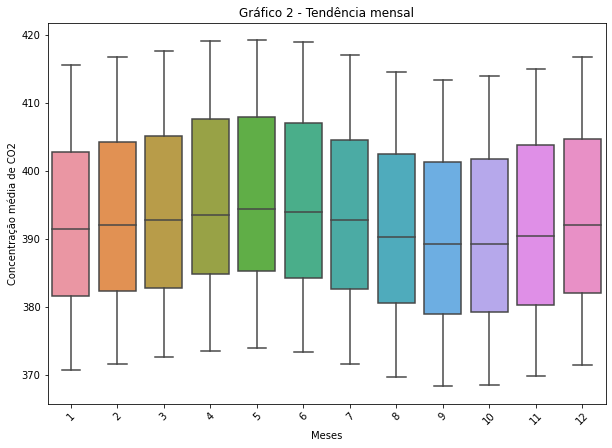

In [8]:
plt.subplots(figsize=(10, 7))
sns.boxplot(x='month', y=target, data=df[df.year>2000])
plt.ylabel('Concentração média de CO2')
plt.xlabel('Meses')
plt.title("Gráfico 2 - Tendência mensal")
plt.xticks(rotation=45)
plt.show()

O próximo gráfico apresenta os valores consolidados por ano; é possível 
perceber novamente uma tendência de crescimento do índice de CO2 no período.

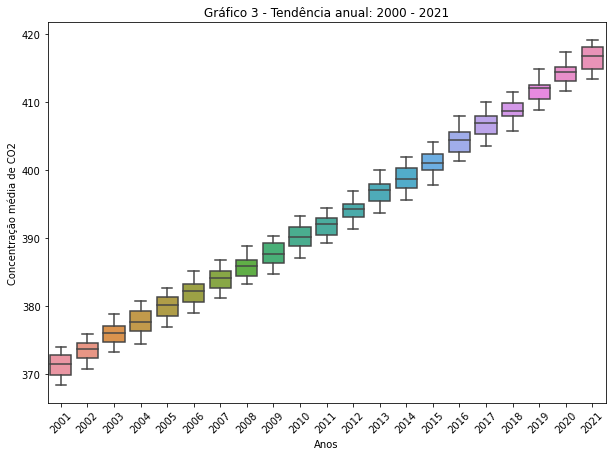

In [9]:
plt.subplots(figsize=(10, 7))
sns.boxplot(x='year', y=target, data=df[df.year>2000])
plt.ylabel('Concentração média de CO2')
plt.xlabel('Anos')
plt.title("Gráfico 3 - Tendência anual: 2000 - 2021")
plt.xticks(rotation=45)
plt.show()

O gráfico seguinte apresenta os dados mensais a cada 5 anos.
É possível observar: 
1) o crescimento no nível de CO2 ao longo dos anos bem como a sazonalidade
anual; 
2) a taxa de crescimento do nível de CO2 ao longo dos anos também 
apresenta um crescimento - por exemplo, a distância entre as curvas de 
2013 e 2018 é maior do que entre as curvas de 1958 e 1063.

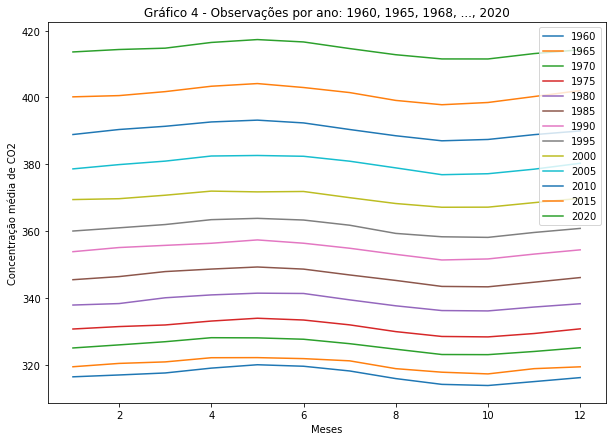

In [10]:
fig, ax = plt.subplots(figsize=(10, 7))
for yr in range (1960, 2023, 5):
    plt.plot('month', target, data=df[df.year == yr], label = yr)
plt.ylabel('Concentração média de CO2')
plt.xlabel('Meses')
plt.title('Gráfico 4 - Observações por ano: 1960, 1965, 1968, ..., 2020')
plt.legend()
plt.show()

In [11]:
def run_linear(train, test, target, features, exp=999):

    """
    Rotina que define, treina e executa um modelo de regressão linear.
    O erro do modelo é calculado usando a métrica RMSE - Root Mean Squared Error.

    Parameters
    ----------
    train : TYPE
        Dados empregados na fase de treino do modelo.
    test : TYPE
        Dados empregados na fase de teste do modelo.
    target : TYPE
        Variável alvo do modelo.
    features : TYPE
        Variaveis independentes empregadas no modelo
    exp : TYPE, optional
        DESCRIPTION. The default is 999.

    Returns
    -------
    None.

    """

    ##print(f'\nModelo linear - {features} *  {target}')
    X_train = train[features]
    y_train = train[target]

    X_test = test[features]
    y_test = test[target]
    
    reg = LinearRegression()
    reg.fit(X_train, y_train)
        
    test_prediction = reg.predict(X_test)
        
    # if target == 'log_average':
    #     v1 = np.exp(y_test)
    #     v2 = np.exp(test_prediction)
    #     poly_reg_rmse = np.sqrt(mean_squared_error(v1, v2))
    #     ##print(f'Erro dos dados de teste:: {round(poly_reg_rmse,3)}')
    # else:
    #     test_error = np.sqrt(mean_squared_error(y_test, test_prediction))
    #     ##print(f'Exp: {exp: }, Erro dos dados de teste: {round(test_error,3)}')
    test_error = np.sqrt(mean_squared_error(y_test, test_prediction))
    return(test_error)


In [12]:
def separa_dados(ano_inicial, nanos_treino, nanos_teste, df):
    
    inicio_treino = date(ano_inicial, 1, 1)
    ano_itr = inicio_treino.year
    ano3_treino = date(ano_inicial+nanos_teste, 1, 1)
    inicio_teste = date(ano_inicial+nanos_treino, 1, 1)
    ano_its = inicio_teste.year
    final_teste = date(ano_inicial+nanos_treino+nanos_teste, 1, 1)
    
    train = df.loc[df.index < str(inicio_teste)].copy()
    train = train[train.index >= str(inicio_treino)]
    
    test = df.loc[df.index >= str(inicio_teste)].copy()
    test = test[test.index < str(final_teste)]
        
#   Calcula valor de referência 

    vreal = test[target]
    vmm1 = vreal.shift()
    vmm1.fillna(method='bfill', inplace=True)
    erro_mm1 = np.sqrt(mean_squared_error(vreal, vmm1))
    #print(f'Erro considerando o valor do último mês: {erro_mm1: .3f}')
    
#   Decomposição da série
    
    sd = seasonal_decompose(train[target], period=12, model = "multiplicative", extrapolate_trend='freq')
    sd = seasonal_decompose(train[target], period=12, extrapolate_trend='freq')
    train['seasonal'] = sd._seasonal
    
    #   Cópia valores da periodocidade para dados de teste
    
    mask = (train.index >= str(inicio_treino)) & (train.index < str(ano3_treino))
    test['seasonal'] = train.loc[mask]['seasonal'].values    
        
    return(train, test)

#   separa_dados

Treinamento de um modelo de regressão linear com variáveis que 
representam o mês e o ano de cada observação e uma sequencia de
variáveis com a concentração de CO2 dos meses anteriores; os dados
de treino cobriam o período de 01 de 1960 a 12 de 2009; os dados 
de teste de 01/2010 a 12/2019. O menor erro medido pela métrica 
rmse foi 0.443.

In [13]:
ano_inicial_treino = 1960   # Ano inicial do período de treino
n_anos_treino = 50          # Duração do período de treino, em anos
n_anos_teste = 10           # Duração do período de treino, em anos

train, test = separa_dados(ano_inicial_treino, n_anos_treino, n_anos_teste, df)

melhor_resultado = 1000
features = ['month', 'year', 'indice'] 

for ind in range(1, 13):
    ncol = 'lag_' + str(ind)
    features.append(ncol)
    erro = run_linear(train, test, target, features, ind) 
    
    print(f'Erro obtido com {ind} variáveis lag: {erro: .3f}')
    if (erro < melhor_resultado):
        melhor_resultado = erro
        nvarlag = ind
#
print(f'\nMelhor resultado obtido: {melhor_resultado: .3f} com {nvarlag} variáveis.')

Erro obtido com 1 variáveis lag:  1.713
Erro obtido com 2 variáveis lag:  1.483
Erro obtido com 3 variáveis lag:  1.142
Erro obtido com 4 variáveis lag:  0.857
Erro obtido com 5 variáveis lag:  0.874
Erro obtido com 6 variáveis lag:  0.878
Erro obtido com 7 variáveis lag:  0.794
Erro obtido com 8 variáveis lag:  0.647
Erro obtido com 9 variáveis lag:  0.487
Erro obtido com 10 variáveis lag:  0.463
Erro obtido com 11 variáveis lag:  0.444
Erro obtido com 12 variáveis lag:  0.443

Melhor resultado obtido:  0.443 com 12 variáveis.


A mesma aboragem anterior, com perído de treino (10 anos,
01/2010 a 12/2019) e teste (2 anos, 01/2020 a 12/2021) menores - 
uma tentativa de explorar a taxa de crescimento da série temporal.
O menor erro obtido foi de 0.331.

In [14]:
ano_inicial_treino = 2010   # Ano inicial do período de treino
n_anos_treino = 10          # Duração do período de treino, em anos
n_anos_teste = 2           # Duração do período de treino, em anos

train, test = separa_dados(ano_inicial_treino, n_anos_treino, n_anos_teste, df)

melhor_resultado = 1000
features = ['month', 'year', 'indice'] 

for ind in range(1, 13):
    ncol = 'lag_' + str(ind)
    features.append(ncol)
    erro = run_linear(train, test, target, features, ind) 
    
    print(f'Erro obtido com {ind} variáveis lag: {erro: .3f}')
    if (erro < melhor_resultado):
        melhor_resultado = erro
        nvarlag = ind
#
print(f'\nMelhor resultado obtido: {melhor_resultado: .3f} com {nvarlag} variáveis.')

Erro obtido com 1 variáveis lag:  1.119
Erro obtido com 2 variáveis lag:  0.606
Erro obtido com 3 variáveis lag:  0.600
Erro obtido com 4 variáveis lag:  0.602
Erro obtido com 5 variáveis lag:  0.587
Erro obtido com 6 variáveis lag:  0.531
Erro obtido com 7 variáveis lag:  0.558
Erro obtido com 8 variáveis lag:  0.529
Erro obtido com 9 variáveis lag:  0.484
Erro obtido com 10 variáveis lag:  0.419
Erro obtido com 11 variáveis lag:  0.331
Erro obtido com 12 variáveis lag:  0.338

Melhor resultado obtido:  0.331 com 11 variáveis.


Utilização de uma janela de treinamento mais curta (120 meses) e 
uma janela de teste com 24 meses; o valor médio do erro nesse 
passo foi de 0.289.

Ano inicial do treino: 1960; ano inicial do teste: 1970; erro:  0.382
Ano inicial do treino: 1962; ano inicial do teste: 1972; erro:  0.608
Ano inicial do treino: 1964; ano inicial do teste: 1974; erro:  0.434
Ano inicial do treino: 1966; ano inicial do teste: 1976; erro:  0.471
Ano inicial do treino: 1968; ano inicial do teste: 1978; erro:  0.495
Ano inicial do treino: 1970; ano inicial do teste: 1980; erro:  0.368
Ano inicial do treino: 1972; ano inicial do teste: 1982; erro:  0.358
Ano inicial do treino: 1974; ano inicial do teste: 1984; erro:  0.328
Ano inicial do treino: 1976; ano inicial do teste: 1986; erro:  0.357
Ano inicial do treino: 1978; ano inicial do teste: 1988; erro:  0.576
Ano inicial do treino: 1980; ano inicial do teste: 1990; erro:  0.374
Ano inicial do treino: 1982; ano inicial do teste: 1992; erro:  0.601
Ano inicial do treino: 1984; ano inicial do teste: 1994; erro:  0.576
Ano inicial do treino: 1986; ano inicial do teste: 1996; erro:  0.455
Ano inicial do trein

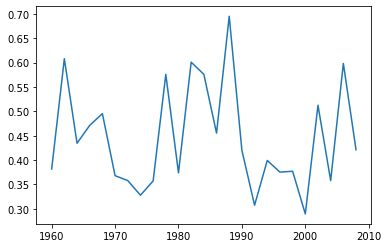


Melhor resultado obtido:  0.289 com 11 variáveis.


In [15]:
melhor_resultado = 1000
erro_acumulado = 0
nrun = 0
vet_ano = []
vet_erro = []

for ano in range(1960, 2010, 2):

    train, test = separa_dados(ano, 10, 2, df)
    features = ['month', 'year', 'indice', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11']
    nrun = nrun + 1
    erro = run_linear(train, test, target, features, 1)
    print(f'Ano inicial do treino: {ano}; ano inicial do teste: {ano+10}; erro: {erro: .3f}' )
    erro_acumulado = erro_acumulado +  erro
    
    vet_ano.append(ano)
    vet_erro.append(erro)
    
    if (erro < melhor_resultado):
        melhor_resultado = erro
#   
print(f'Erro médio: {erro_acumulado / nrun: .3f}')
print(f'Melhor resultado obtido: {melhor_resultado: .3f}')
plt.plot(vet_ano, vet_erro)
plt.show()

print(f'\nMelhor resultado obtido: {melhor_resultado: .3f} com {nvarlag} variáveis.')

Utilização de mais uma variável independente, que representa a 
szonalidade da série temporal analisada, obtida pela rotina seasonal_decompose,
disponível no módulo statsmodels.tsa.seasonal, que decompÕe uma série temporal 
em 3 componentes: tendência sazonalidade e ruído; também foram 
empregadas as jamelas utilizadas nos passo anterior. Nesse caso 
o valor médio do erro foi de 0.235.

Ano inicial do treino: 1960; ano inicial do teste: 1970; erro:  0.349
Ano inicial do treino: 1962; ano inicial do teste: 1972; erro:  0.569
Ano inicial do treino: 1964; ano inicial do teste: 1974; erro:  0.386
Ano inicial do treino: 1966; ano inicial do teste: 1976; erro:  0.452
Ano inicial do treino: 1968; ano inicial do teste: 1978; erro:  0.454
Ano inicial do treino: 1970; ano inicial do teste: 1980; erro:  0.377
Ano inicial do treino: 1972; ano inicial do teste: 1982; erro:  0.368
Ano inicial do treino: 1974; ano inicial do teste: 1984; erro:  0.235
Ano inicial do treino: 1976; ano inicial do teste: 1986; erro:  0.364
Ano inicial do treino: 1978; ano inicial do teste: 1988; erro:  0.567
Ano inicial do treino: 1980; ano inicial do teste: 1990; erro:  0.399
Ano inicial do treino: 1982; ano inicial do teste: 1992; erro:  0.592
Ano inicial do treino: 1984; ano inicial do teste: 1994; erro:  0.557
Ano inicial do treino: 1986; ano inicial do teste: 1996; erro:  0.389
Ano inicial do trein

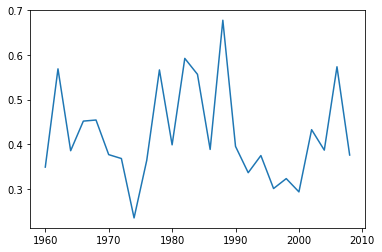

In [16]:
melhor_resultado = 1000
erro_acumulado = 0
nrun = 0
vet_ano = []
vet_erro = []

for ano in range(1960, 2010, 2):

    train, test = separa_dados(ano, 10, 2, df)
    features = ['month', 'year', 'indice', 'seasonal', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11']
    nrun = nrun + 1
    erro = run_linear(train, test, target, features, 1)
    print(f'Ano inicial do treino: {ano}; ano inicial do teste: {ano+10}; erro: {erro: .3f}' )
    #print(f'Erro obtido: {erro: .3f}')
    #print(f'Erro obtido: {erro: .3f}')
    erro_acumulado = erro_acumulado +  erro
    
    vet_ano.append(ano)
    vet_erro.append(erro)
    
    if (erro < melhor_resultado):
        melhor_resultado = erro
#   
print(f'Erro médio: {erro_acumulado / nrun: .3f}')
print(f'Melhor resultado obtido: {melhor_resultado: .3f}')
plt.plot(vet_ano, vet_erro)
plt.show()